<a href="https://colab.research.google.com/github/shrutidhingra05/flight-price/blob/main/flightpricepredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_absolute_error, r2_score

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import OneHotEncoder

from scipy import stats

sns.set_style("whitegrid")

In [ ]:
df = pd.read_csv("/content/Clean_Dataset.csv",index_col=0)
print("There are {} observations for {} predictors.".format(df.shape[0],df.shape[1]))
df.head()

There are 300153 observations for 11 predictors.


,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df.isnull().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [ ]:
df.describe(include='all')

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
count,300153,300153,300153,300153,300153,300153,300153,300153,300153.000000,300153.000000,300153.000000
unique,6,1561,6,6,3,6,6,2,NaN,NaN,NaN
top,Vistara,UK-706,Delhi,Morning,one,Night,Mumbai,Economy,NaN,NaN,NaN
freq,127859,3235,61343,71146,250863,91538,59097,206666,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.221021,26.004751,20889.660523
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.191997,13.561004,22697.767366
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.830000,1.000000,1105.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.830000,15.000000,4783.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.250000,26.000000,7425.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.170000,38.000000,42521.000000


<Axes: xlabel='price'>

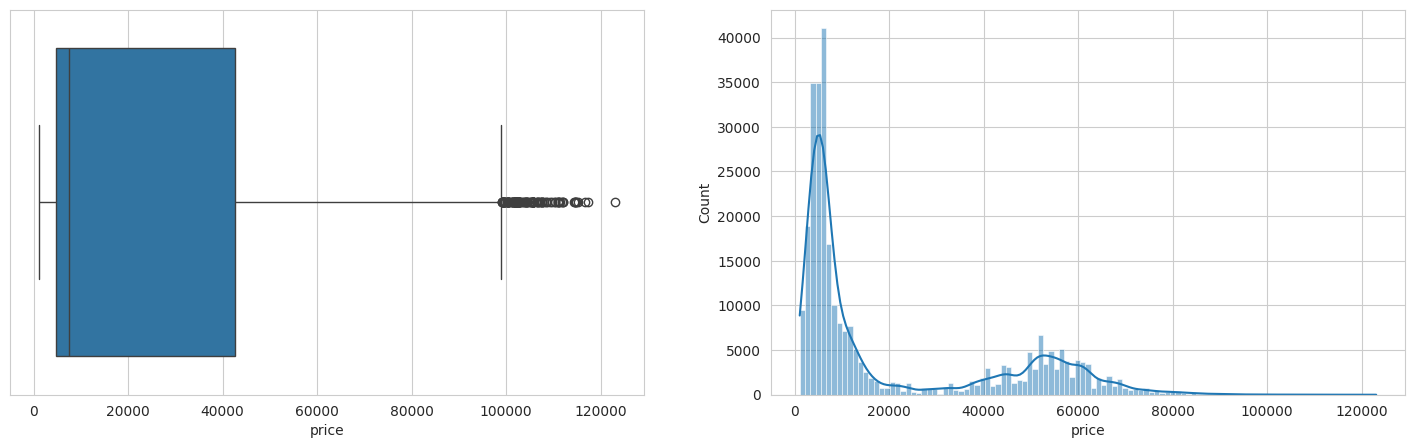

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,2)
sns.histplot(x = 'price', data = df, kde = True)
plt.subplot(1,2,1)
sns.boxplot(x = 'price', data = df)

How does the ticket price vary between economy and business class?


Text(0.5, 1.0, 'Airline prices based on the class and company')

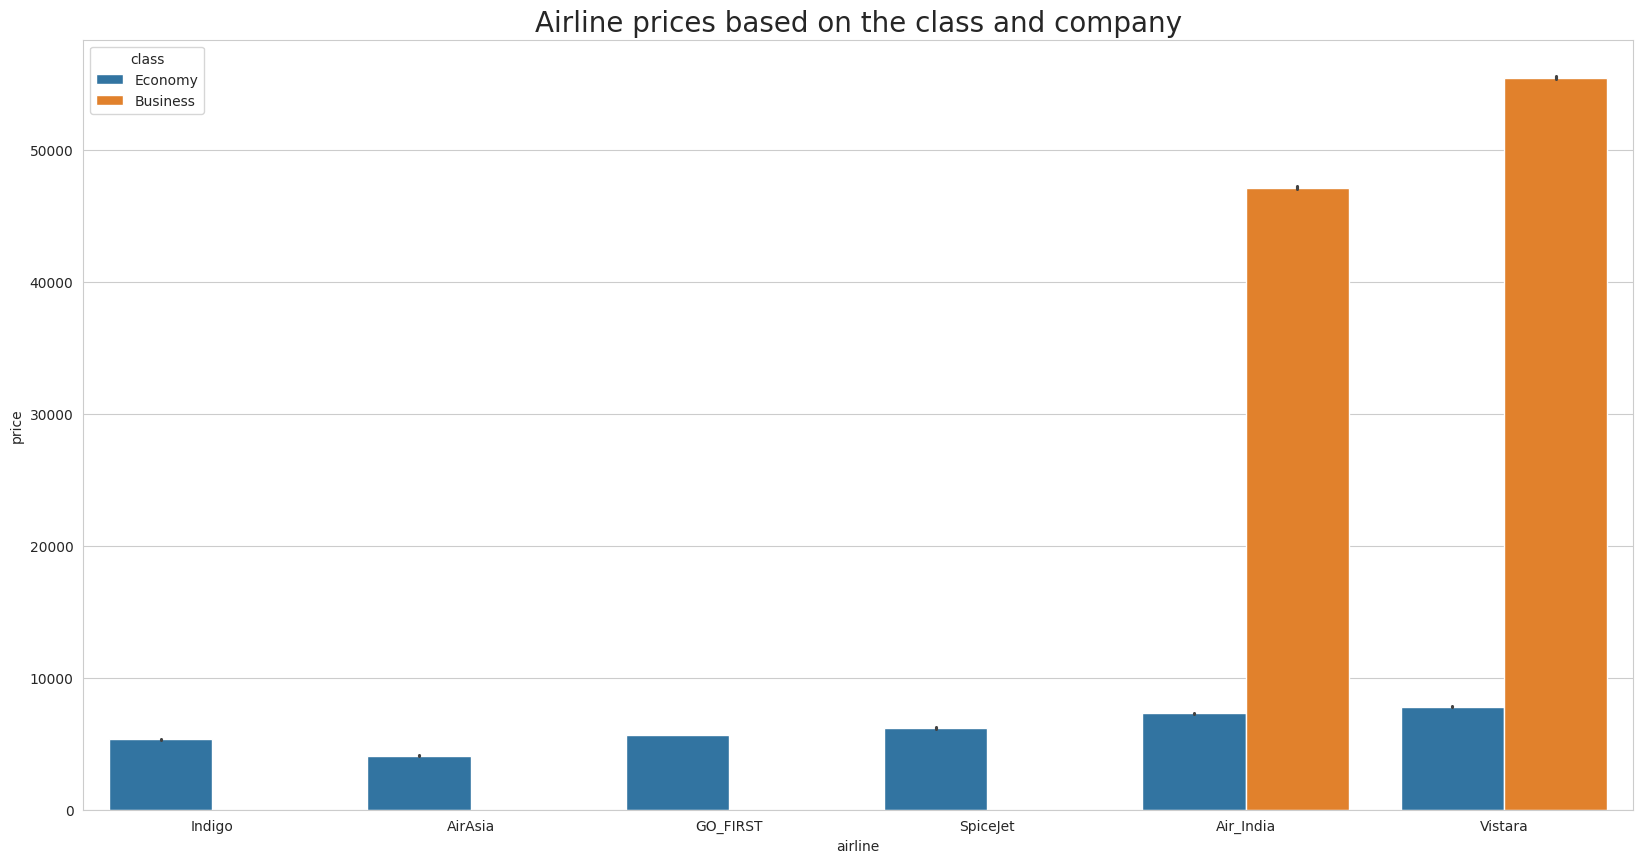

In [ ]:
plt.figure(figsize=(20, 10))
sns.barplot(x='airline',y='price',hue="class",data=df.sort_values("price")).set_title('Airline prices based on the class and company',fontsize=20)

Does price vary with airlines

Text(0.5, 1.0, 'Airline prices based on companies for business tickets')

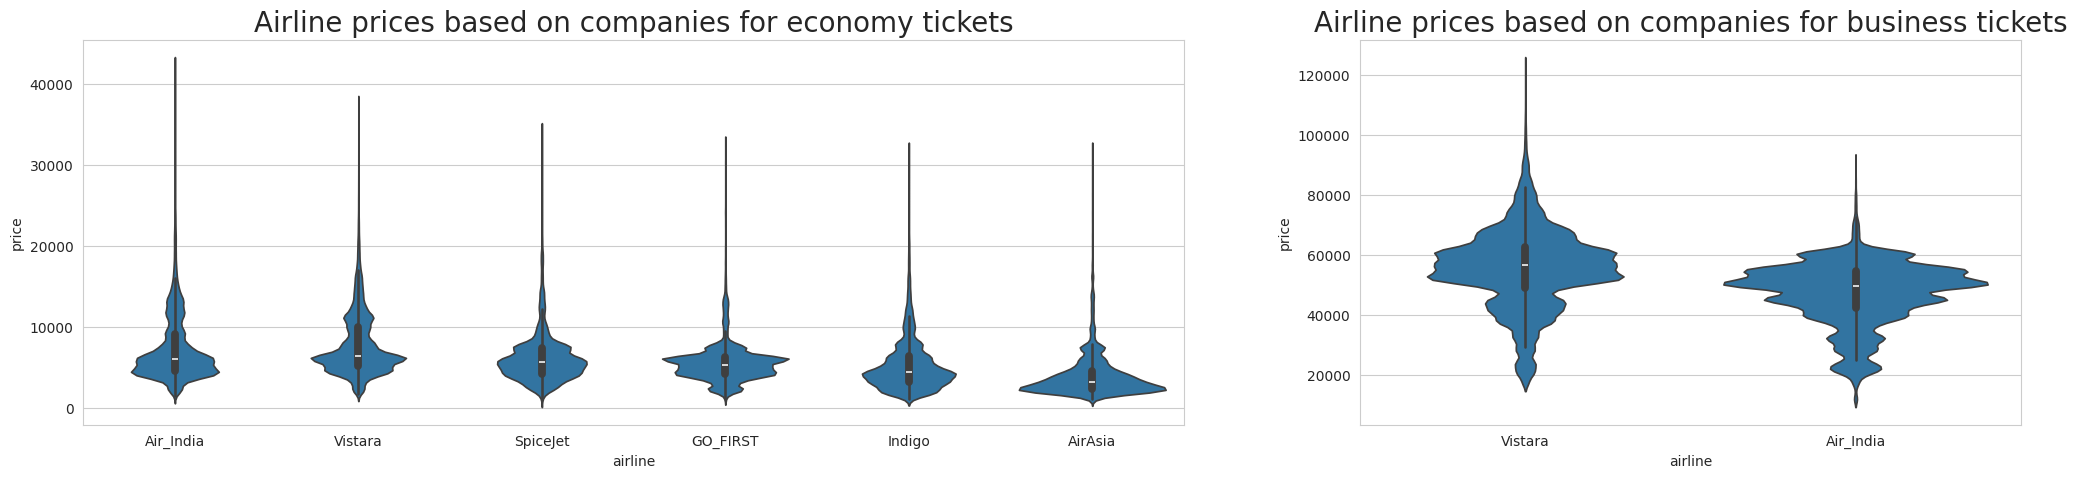

In [ ]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), ax=axs[0])
axs[0].set_title("Airline prices based on companies for economy tickets",fontsize=20)
sns.violinplot(y = "price", x = "airline",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), ax=axs[1])
axs[1].set_title("Airline prices based on companies for business tickets",fontsize=20)

How is the price affected when tickets are bought in just 1 or 2 days before departure?

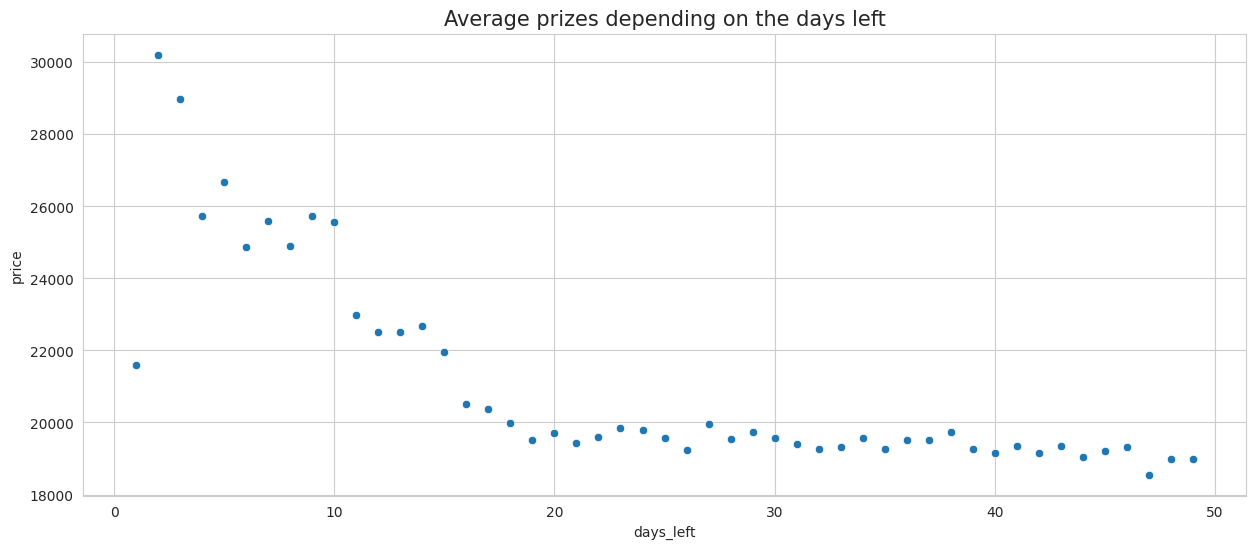

In [ ]:
df_temp = df.groupby(['days_left'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="days_left", y="price", data=df_temp).set_title("Average prizes depending on the days left",fontsize=15)

<Axes: xlabel='days_left', ylabel='price'>

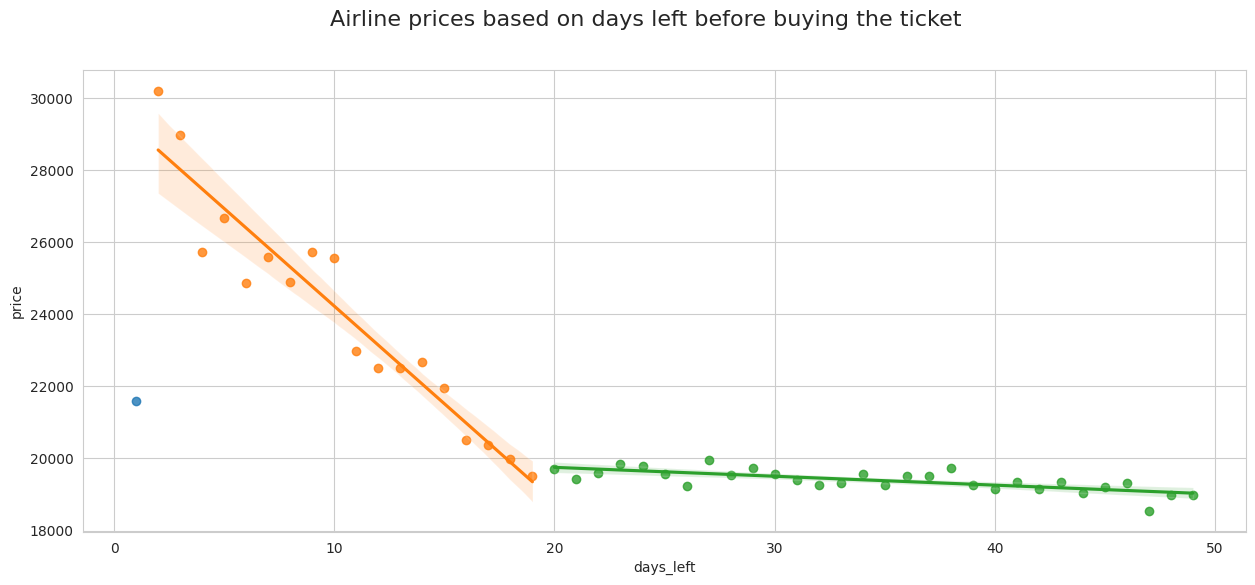

In [ ]:
plt.figure(figsize=(15,6)).suptitle('Airline prices based on days left before buying the ticket', fontsize=16)
ax = plt.axes()
sns.regplot(x=df_temp.loc[df_temp["days_left"]==1].days_left, y=df_temp.loc[df_temp["days_left"]==1].price, fit_reg=False, ax=ax)
sns.regplot(x=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].days_left, y=df_temp.loc[(df_temp["days_left"]>1)&(df_temp["days_left"]<20)].price, fit_reg=True, ax=ax)
sns.regplot(x=df_temp.loc[df_temp["days_left"]>=20].days_left, y=df_temp.loc[df_temp["days_left"]>=20].price, fit_reg=True, ax=ax)

Does the price change with the duration of the flight?

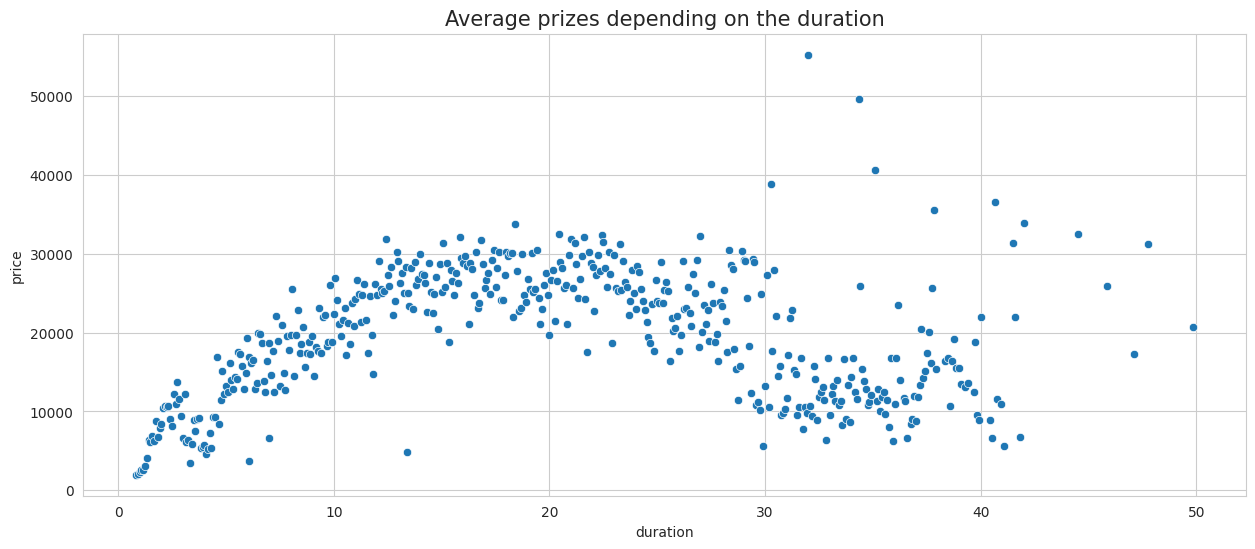

In [ ]:
df_temp = df.groupby(['duration'])['price'].mean().reset_index()

plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)

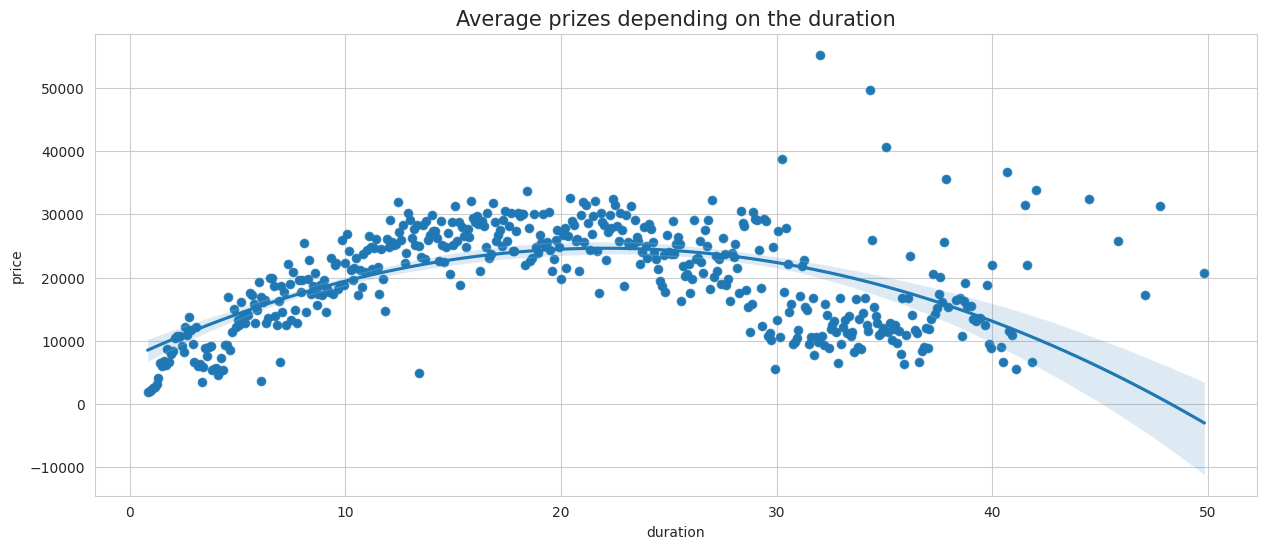

In [ ]:
plt.figure(figsize=(15,6))
ax = sns.scatterplot(x="duration", y="price", data=df_temp).set_title("Average prizes depending on the duration",fontsize=15)
ax = sns.regplot(x="duration", y="price", data=df_temp, order=2)

Does ticket price change based on the departure time and arrival time?

Text(0.5, 1.0, 'Airline prices based on the arrival time')

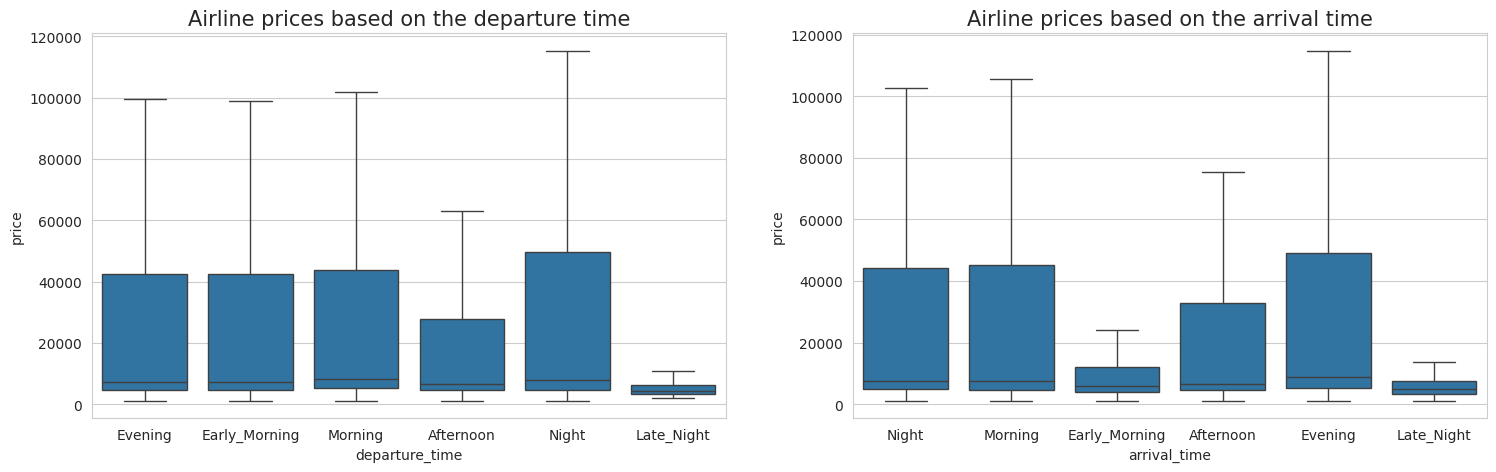

In [ ]:
plt.figure(figsize = (18,5))
plt.subplot(1,2,1)
sns.boxplot(data=df, y="price", x="departure_time",showfliers=False).set_title("Airline prices based on the departure time",fontsize=15)
plt.subplot(1,2,2)
sns.boxplot(data=df, y="price", x="arrival_time",showfliers=False).set_title("Airline prices based on the arrival time",fontsize=15)

How the price changes with change in Source and Destination?

Text(0.5, 0.98, 'Airline prices based on the source and destination cities')

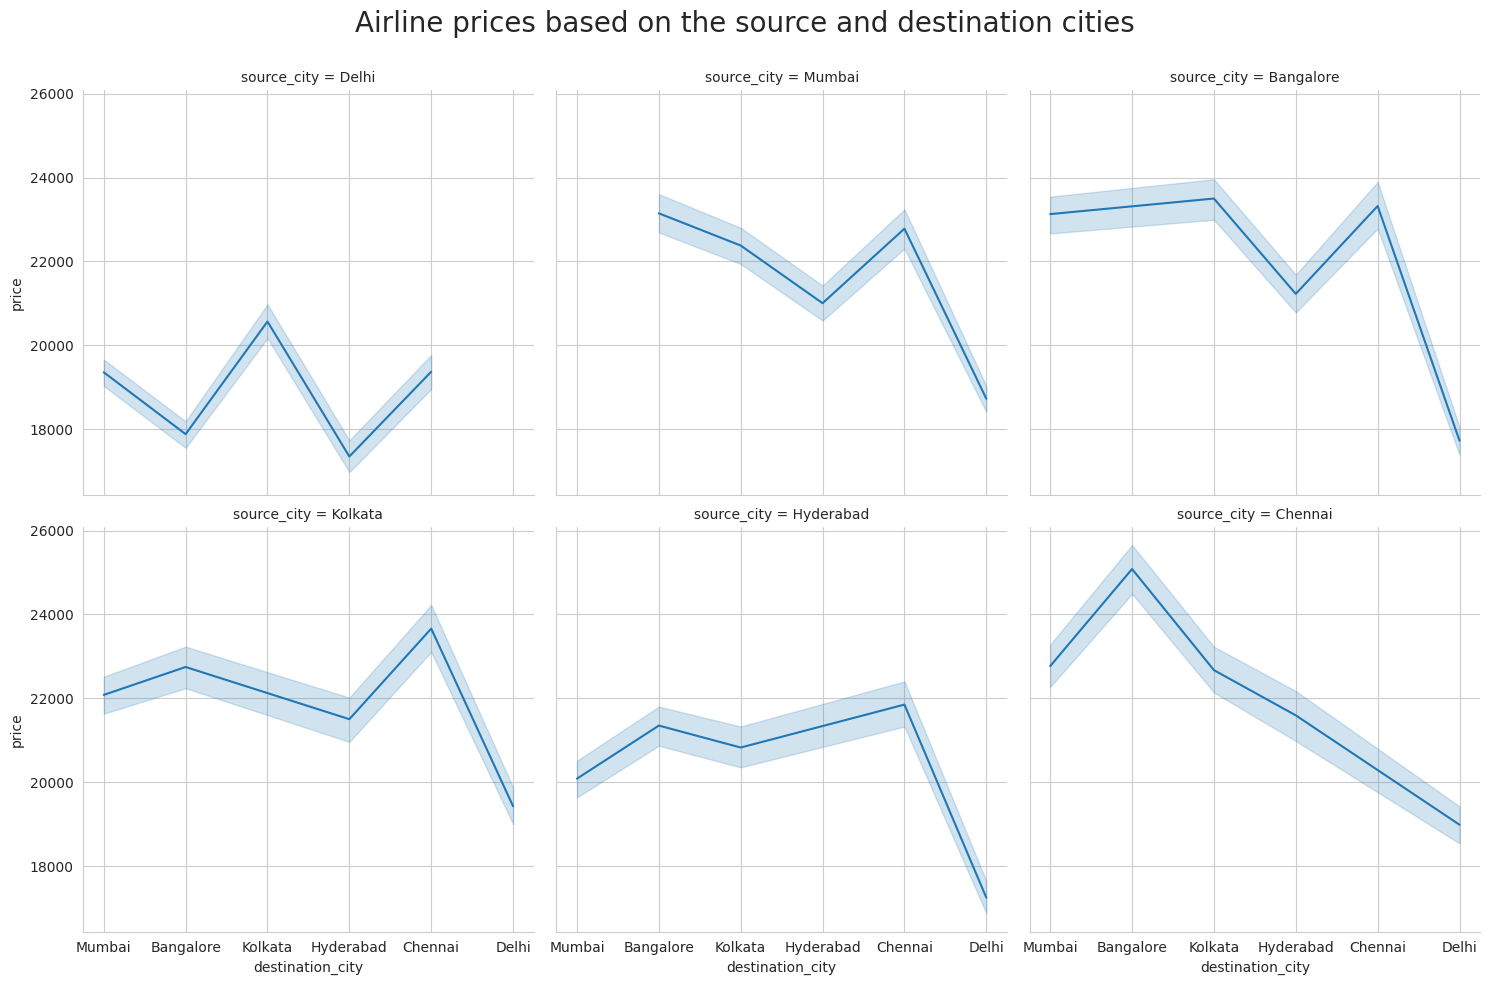

In [ ]:
ax = sns.relplot(col="source_city", y="price", kind="line",x='destination_city', data=df, col_wrap=3)
ax.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
ax.fig.suptitle('Airline prices based on the source and destination cities',fontsize=20)

Does the number of stops influences the price?

Text(0.5, 1.0, 'Airline prices based on the number of stops  for business')

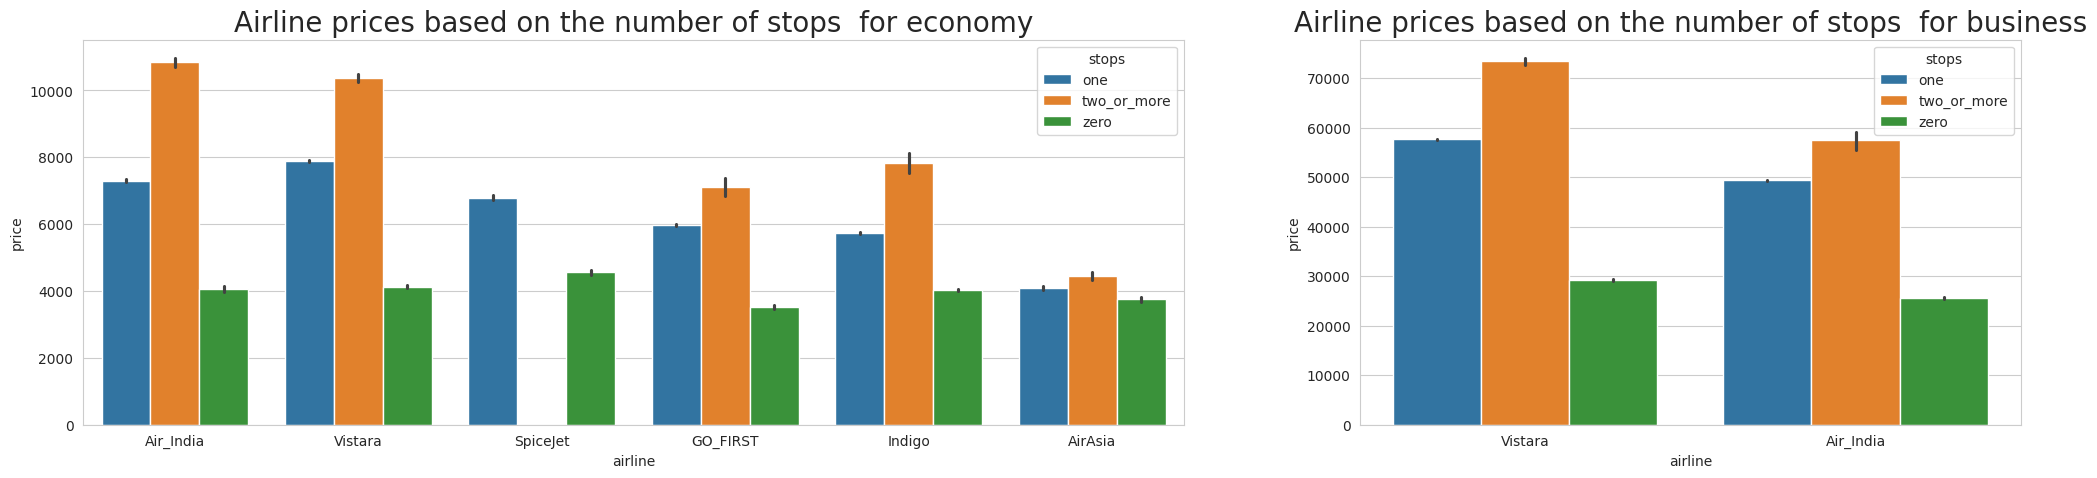

In [ ]:
fig, axs = plt.subplots (1, 2, gridspec_kw={'width_ratios': [5, 3]}, figsize=(25, 5))
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Economy'].sort_values("price", ascending = False), ax=axs[0])
axs[0].set_title("Airline prices based on the number of stops  for economy",fontsize=20)
sns.barplot(y = "price", x = "airline",hue="stops",data = df.loc[df["class"]=='Business'].sort_values("price", ascending = False), ax=axs[1])
axs[1].set_title("Airline prices based on the number of stops  for business",fontsize=20)

What variables influence most the price?

In [ ]:
def preprocessing(df):
    #Encode the ordinal variables "stops" and "class".
    df["stops"] = df["stops"].replace({'zero':0,'one':1,'two_or_more':2}).astype(int)
    df["class"] = df["class"].replace({'Economy':0,'Business':1}).astype(int)

    #Create the dummy variables for the cities, the times and the airlines.
    dummies_variables = ["airline","source_city","destination_city","departure_time","arrival_time"]
    dummies = pd.get_dummies(df[dummies_variables], drop_first= True)
    df = pd.concat([df,dummies],axis=1)

    #Create the dummy variables for the cities, the times and the airlines.
    df = df.drop(["flight","airline","source_city","destination_city","departure_time","arrival_time"],axis=1)

    return df

In [ ]:
df_preprocessed = preprocessing(df)

<Axes: >

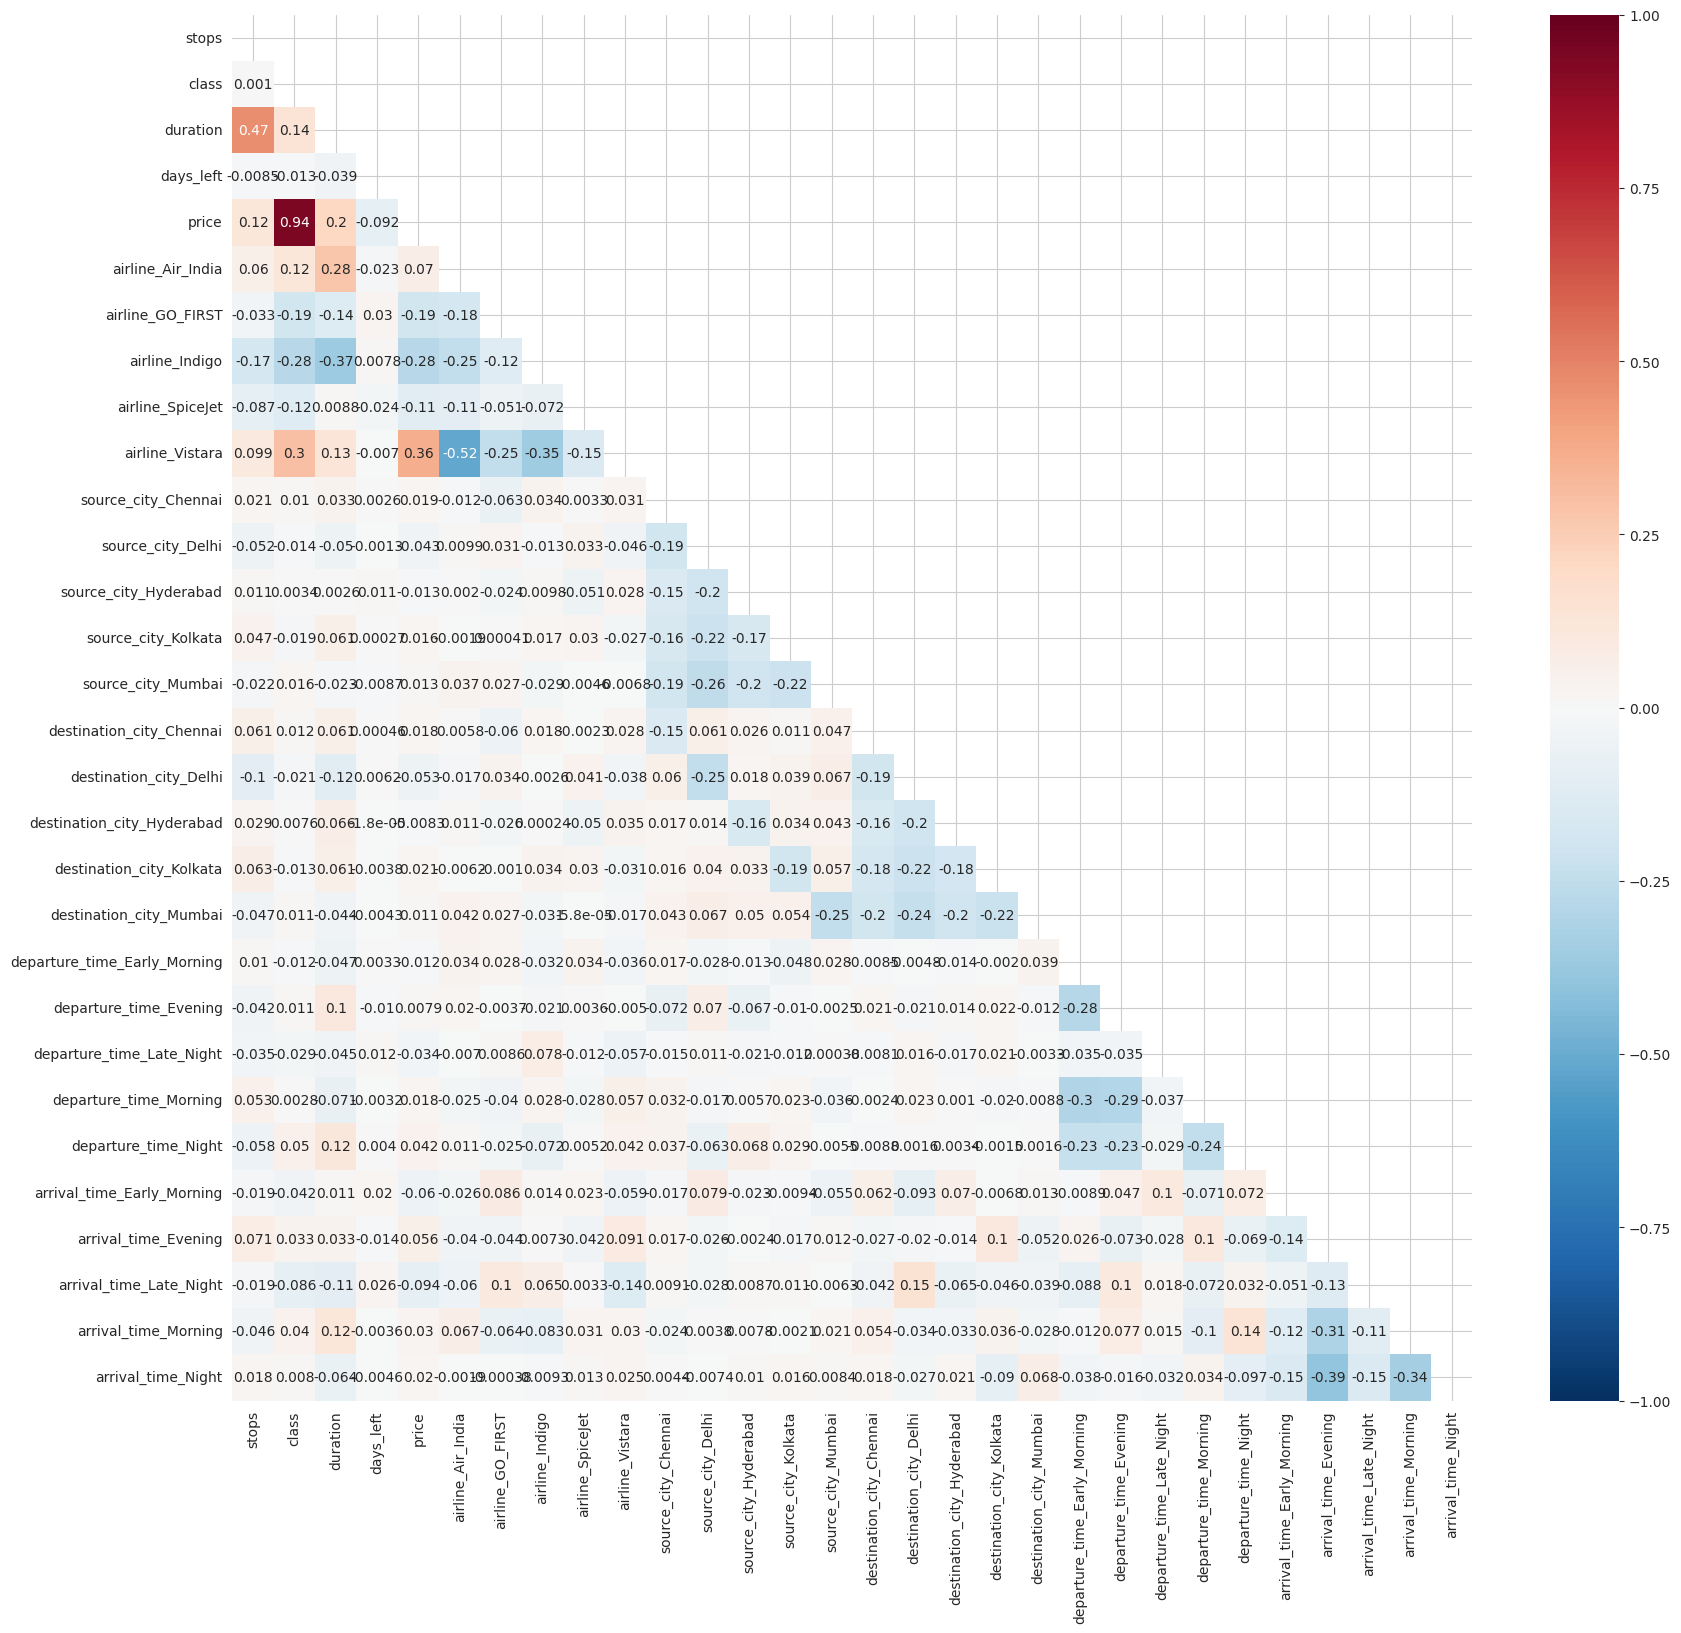

In [ ]:
mask = np.triu(np.ones_like(df_preprocessed.corr(), dtype=bool))

plt.figure(figsize = (20,18))
sns.heatmap(df_preprocessed.corr(), mask=mask,annot = True, vmin= -1.0, vmax= 1.0, center = 0, cmap = 'RdBu_r')

In [ ]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [ ]:
X = df_preprocessed.copy()
y = X.pop("price")

mi_scores = make_mi_scores(X, y)
print(mi_scores.sort_values(ascending=False))

duration                        2.415277
class                           0.618093
airline_Vistara                 0.517385
days_left                       0.477406
source_city_Delhi               0.430462
source_city_Mumbai              0.428634
airline_Air_India               0.403297
stops                           0.392738
destination_city_Delhi          0.387216
destination_city_Mumbai         0.382443
source_city_Kolkata             0.360909
source_city_Hyderabad           0.346552
destination_city_Kolkata        0.339796
source_city_Chennai             0.325926
destination_city_Hyderabad      0.318186
destination_city_Chennai        0.302343
airline_Indigo                  0.286906
airline_GO_FIRST                0.202483
arrival_time_Evening            0.127975
arrival_time_Night              0.106256
departure_time_Evening          0.104635
arrival_time_Morning            0.102338
departure_time_Morning          0.092502
departure_time_Early_Morning    0.089224
airline_SpiceJet

Prediction of flight prices

In [ ]:
def load_data():
    # Read data
    df = pd.read_csv("https://raw.githubusercontent.com/julienjta/Data-Science-Portfolio/main/Project%201/data/dataset.csv",index_col=0)
    # Preprocessing the data

    df = preprocessing(df)

    X = df.copy()
    y = X.pop("price")

    xtrain,xtest,ytrain,ytest = train_test_split(X,y,random_state = 1,test_size=0.3, shuffle=True)

    return xtrain,xtest,ytrain,ytest

In [ ]:
xtrain,xtest,ytrain,ytest = load_data()

Define the best model

In [ ]:
models = {}

models["KNeighborsRegressor"]={"model":KNeighborsRegressor(n_neighbors=50)}
models["LinearRegression"]={"model":LinearRegression()}
models["XGBRegressor"]={"model":XGBRegressor(n_jobs=5,learning_rate=0.1,max_depth=10,random_state=1)}

In [ ]:
def score_dataset(X, y, model=XGBRegressor()):
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes

    score_r2 = cross_val_score(model, X, y, cv=5, scoring="r2")
    score_r2 = score_r2.mean()

    return score_r2

In [ ]:
def get_scores(models,xtrain,ytrain):
    for name,model in models.items():
        model["model"].fit(xtrain,ytrain)

        score_r2 = score_dataset(xtrain, ytrain, model=model["model"])
        score = {'model':"Linear regression", 'score_r2':score_r2}
        print("--- "+name+" ---")
        print("Score r2: {}".format(score_r2))
        print("\n")

In [ ]:
get_scores(models,xtrain,ytrain)

--- KNeighborsRegressor ---
Score r2: 0.70913727980577


--- LinearRegression ---
Score r2: 0.9095338142489373


--- XGBRegressor ---
Score r2: 0.9822407075983479




Apply the model on the test dataset

In [ ]:
model = models["XGBRegressor"]["model"]
model.fit(xtrain,ytrain)
ypred = model.predict(xtest)

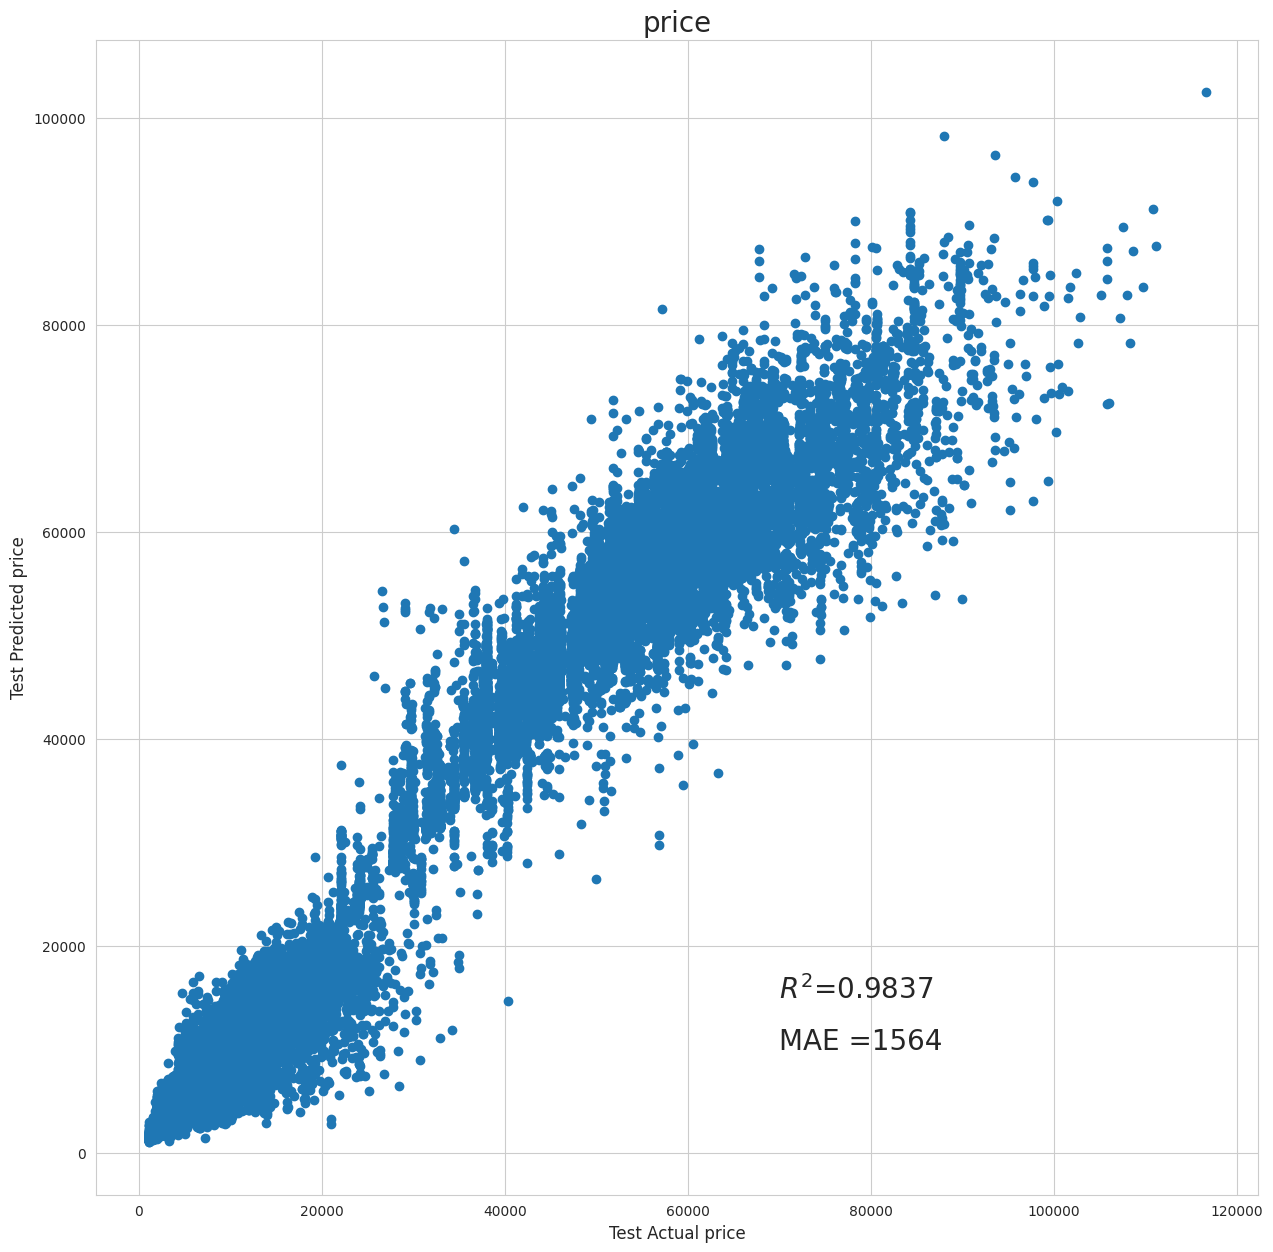

In [ ]:
fig,ax = plt.subplots(figsize=(15,15))
ax.set_title("price",fontsize=20)
ax.set_ylabel('Test Predicted price',fontsize=12)
ax.set_xlabel('Test Actual price',fontsize=12)
ax.scatter(ytest,ypred)

score_r2 = r2_score(ytest, ypred)
score_mae = mean_absolute_error(ytest, ypred)
plt.text(70000,15000,'$ R^{2} $=' + str(round(score_r2, 4)),fontsize=20)
plt.text(70000,10000,'MAE =' + str(round(score_mae)),fontsize=20)
plt.show()

In [ ]:
# Data preprocessing: One-hot encoding for categorical variables
data = pd.get_dummies(df)

# Split the data into features and target variable
X = data.drop(columns=['price'])
y = data['price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'KNeighborsRegressor': KNeighborsRegressor(),
    'XGBRegressor': XGBRegressor()
}

best_model_name = None
best_model_score = -1
best_price = None

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model: {name}, R-squared: {r2}, Mean Absolute Error: {mae}")
    if r2 > best_model_score:
        best_model_score = r2
        best_model_name = name
        best_price = y_pred

print(f"The best model for airline price prediction is: {best_model_name} with an R-squared score of {best_model_score}")

# Now, find the best price of the airline to and fro from a destination
best_price_index = best_price.argmin()
best_price_value = best_price[best_price_index]
print(f"The best price for the airline to and fro from a destination is: {best_price_value}")


Model: Linear Regression, R-squared: -2.4988890331897576e+16, Mean Absolute Error: 25371915965.03515
Model: KNeighborsRegressor, R-squared: 0.4934237403621301, Mean Absolute Error: 11664.232956305908
Model: XGBRegressor, R-squared: 0.9768104233137088, Mean Absolute Error: 1978.4503520410126
The best model for airline price prediction is: XGBRegressor with an R-squared score of 0.9768104233137088
The best price for the airline to and fro from a destination is: 987.2581176757812


In [ ]:
print(df.columns)
# Check if the 'airline' column exists
if 'airline' in df.columns:
    print("The 'airline' column exists in the data DataFrame.")
else:
    print("The 'airline' column does not exist in the data DataFrame.")

# Get the corresponding airline name using the index
best_airline_name = df.iloc[best_price_index]['airline']

# Print the best airline name and best price
print(f"The best airline for the destination is: {best_airline_name}")
print(f"The best price for the airline to and fro from a destination is: {best_price_value}")

Index(['airline', 'flight', 'source_city', 'departure_time', 'stops',
       'arrival_time', 'destination_city', 'class', 'duration', 'days_left',
       'price'],
      dtype='object')
The 'airline' column exists in the data DataFrame.
The best airline for the destination is: Air_India
The best price for the airline to and fro from a destination is: 987.2581176757812
